# Catboost Playground 
This notebook goal is to show off Catboost functions and attributes.

## Amazon Employee Access Challenge
The objective of this competition is to build a model, learned using historical data, that will determine an employee's access needs, such that manual access transactions (grants and revokes) are minimized as the employee's attributes change over time. The model will take an employee's role information and a resource code and will return whether or not access should be granted.

## Environment Setup

### Imports

In [4]:
import time
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import catboost
import catboost.datasets
import xgboost
import lightgbm as lgb
import numpy as np
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
from copy import deepcopy
import pprint
pp = pprint.PrettyPrinter(indent=4)
% matplotlib inline

UsageError: Line magic function `%` not found.


### Load Data

In [5]:
train = pd.read_csv('data/train_final.csv', index_col = "Id")
test = pd.read_csv('data/test_final.csv', index_col = "Id")

## Short EDA

Just to get some intuition about the Dataset 

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
ACTION              32769 non-null int64
RESOURCE            32769 non-null int64
MGR_ID              32769 non-null int64
ROLE_ROLLUP_1       32769 non-null int64
ROLE_ROLLUP_2       32769 non-null int64
ROLE_DEPTNAME       32769 non-null int64
ROLE_TITLE          32769 non-null int64
ROLE_FAMILY_DESC    32769 non-null int64
ROLE_FAMILY         32769 non-null int64
ROLE_CODE           32769 non-null int64
dtypes: int64(10)
memory usage: 2.5 MB


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58921 entries, 0 to 58920
Data columns (total 10 columns):
id                  58921 non-null int64
RESOURCE            58921 non-null int64
MGR_ID              58921 non-null int64
ROLE_ROLLUP_1       58921 non-null int64
ROLE_ROLLUP_2       58921 non-null int64
ROLE_DEPTNAME       58921 non-null int64
ROLE_TITLE          58921 non-null int64
ROLE_FAMILY_DESC    58921 non-null int64
ROLE_FAMILY         58921 non-null int64
ROLE_CODE           58921 non-null int64
dtypes: int64(10)
memory usage: 4.5 MB


In [6]:
for col in train_df.columns:
    print("{}: {}".format(col, len(train_df[col].unique())))

ACTION: 2
RESOURCE: 7518
MGR_ID: 4243
ROLE_ROLLUP_1: 128
ROLE_ROLLUP_2: 177
ROLE_DEPTNAME: 449
ROLE_TITLE: 343
ROLE_FAMILY_DESC: 2358
ROLE_FAMILY: 67
ROLE_CODE: 343


In [7]:
train_df.describe()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
count,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000
mean,0.942110,42923.916171,25988.957979,116952.627788,118301.823156,118912.779914,125916.152644,170178.369648,183703.408893,119789.430132
std,0.233539,34173.892702,35928.031650,10875.563591,4551.588572,18961.322917,31036.465825,69509.462130,100488.407413,5784.275516
min,0.000000,0.000000,25.000000,4292.000000,23779.000000,4674.000000,117879.000000,4673.000000,3130.000000,117880.000000
25%,1.000000,20299.000000,4566.000000,117961.000000,118102.000000,118395.000000,118274.000000,117906.000000,118363.000000,118232.000000
50%,1.000000,35376.000000,13545.000000,117961.000000,118300.000000,118921.000000,118568.000000,128696.000000,119006.000000,118570.000000
75%,1.000000,74189.000000,42034.000000,117961.000000,118386.000000,120535.000000,120006.000000,235280.000000,290919.000000,119348.000000
max,1.000000,312153.000000,311696.000000,311178.000000,286791.000000,286792.000000,311867.000000,311867.000000,308574.000000,270691.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c9acf28>,
      dtype=object)

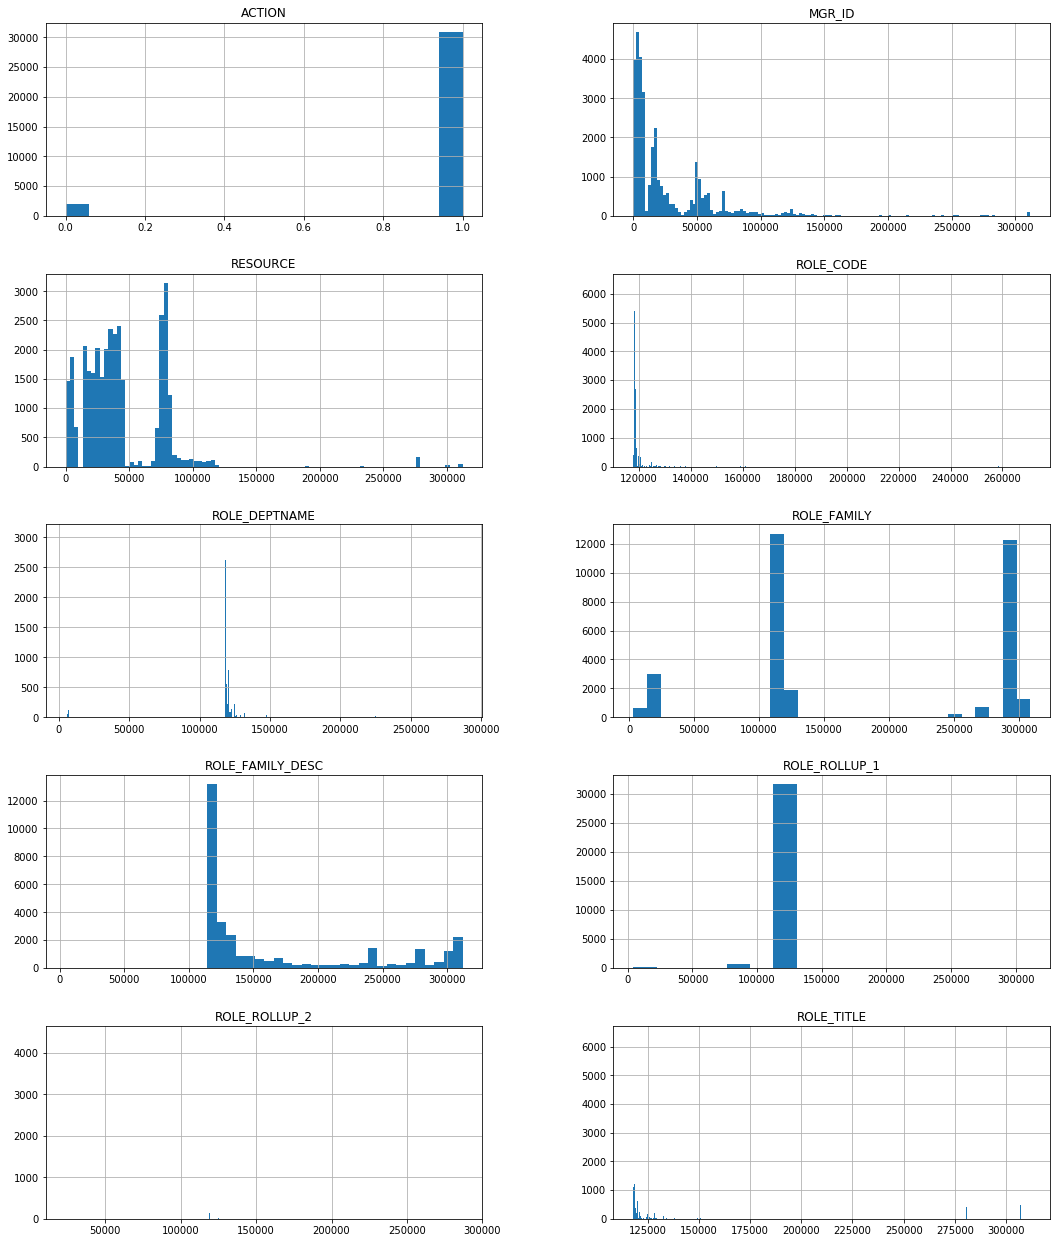

In [10]:
train_df.hist(bins='auto', figsize=(18, 22), layout=(5, 2))

let's check the positive to negative target variable ratio

In [8]:
(train_df["ACTION"] == 1).sum() / (train_df["ACTION"] == 0).sum()

16.274117026884554

//anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
//anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
//anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
//anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


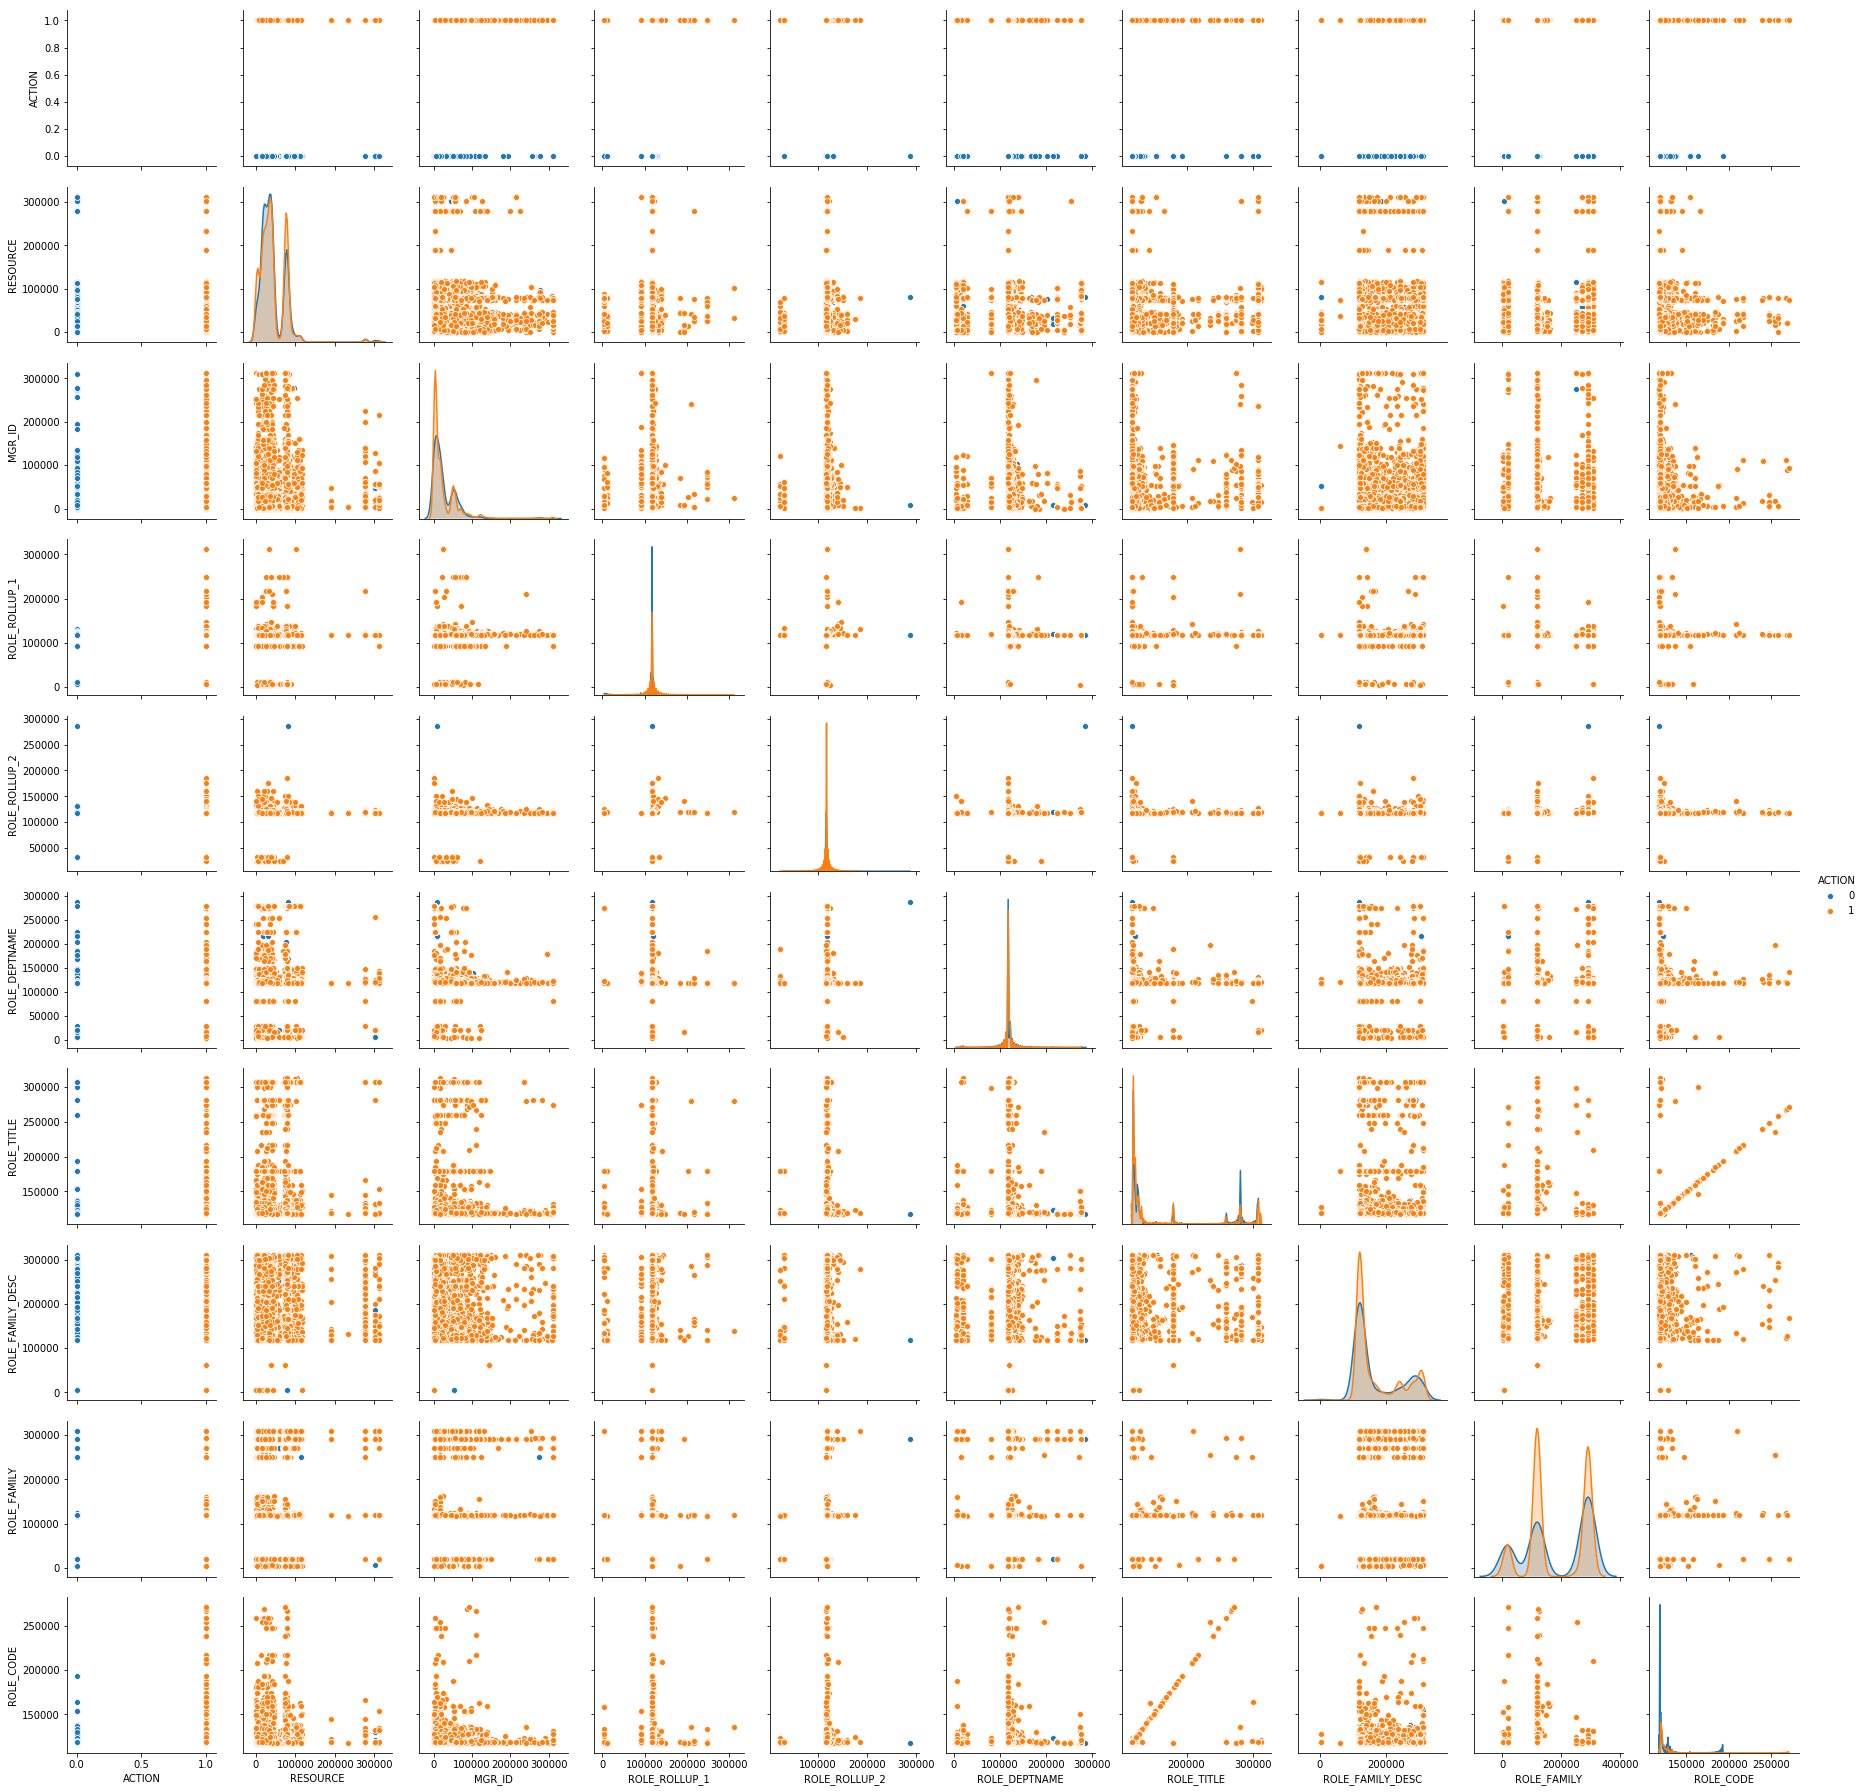

In [11]:
sns.pairplot(train_df, hue="ACTION")

### EDA Conclusions

1. All features are categorical
    - Since the categorical features have a lot of unique values, we won't use one hot encoding, but depending on the dataset it may be a good idea to adjust one_hot_max_size.
2. No missing values.
3. Imbalanced learning with ratio of 1:16, can use oversampling\undersampling techniques. But that's out of the focus of this notebook. we can try scale

## Train Test Split

In [6]:
y_train = train["Y"]
X_train = train.drop("Y", axis=1)
X_test = test

This time all the columns are categorical, but this is unusual, so I'll give you an extra option for the columns subset case

In [7]:
categorical_columns = X_train.columns
categorical_columns_indices = list(range(len(X_train.columns))) # or [X_train.index.get_loc(col) for categorical_columns]

## Modeling

#### Comparison
I will compare 4 approaches:<br>
    • **XGBoost** with **greedy** parameter tuning.<br>
    • **XGBoost** with **bayesian** optimization.<br>
    • **Catboost** with **greedy** parameter tuning.<br>
    • **Catboost** with **bayesian** optimization.<br>
<br>


#### ModelOptimizer
In order to reuse code, and since I'm running optimizations step by step, I wrote this simple optimizer class which uses skopt, but you can optimize your models in whatever way you like.

In [10]:
class ModelOptimizer:
    best_score = None
    opt = None
    
    def __init__(self, model, X_train, y_train, categorical_columns_indices=None, n_fold=3, seed=2405, early_stopping_rounds=30, is_stratified=True, is_shuffle=True):
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.categorical_columns_indices = categorical_columns_indices
        self.n_fold = n_fold
        self.seed = seed
        self.early_stopping_rounds = early_stopping_rounds
        self.is_stratified = is_stratified
        self.is_shuffle = is_shuffle
        
        
    def update_model(self, **kwargs):
        for k, v in kwargs.items():
            setattr(self.model, k, v)
            
    def evaluate_model(self):
        pass
    
    def optimize(self, param_space, max_evals=10, n_random_starts=2):
        start_time = time.time()
        
        @use_named_args(param_space)
        def _minimize(**params):
            self.model.set_params(**params)
            return self.evaluate_model()
        
        opt = gp_minimize(_minimize, param_space, n_calls=max_evals, n_random_starts=n_random_starts, random_state=2405, n_jobs=-1)
        best_values = opt.x
        optimal_values = dict(zip([param.name for param in param_space], best_values))
        best_score = opt.fun
        self.best_score = best_score
        self.opt = opt
        
        print('optimal_parameters: {}\noptimal score: {}\noptimization time: {}'.format(optimal_values, best_score, time.time() - start_time))
        print('updating model with optimal values')
        self.update_model(**optimal_values)
        plot_convergence(opt)
        return optimal_values
    
class CatboostOptimizer(ModelOptimizer):
    def evaluate_model(self):
        validation_scores = catboost.cv(
        catboost.Pool(self.X_train, 
                      self.y_train, 
                      cat_features=self.categorical_columns_indices),
        self.model.get_params(), 
        nfold=self.n_fold,
        stratified=self.is_stratified,
        seed=self.seed,
        early_stopping_rounds=self.early_stopping_rounds,
        shuffle=self.is_shuffle,
        # metric='auc',
        plot=False)
        self.scores = validation_scores
        test_scores = validation_scores.iloc[:, 2]
        best_metric = test_scores.max()
        return 1 - best_metric

# XGBoost

### Default Params

In [40]:
default_xgb = xgboost.XGBClassifier(
        objective='binary:logistic',
        n_jobs=-1
    )

default_xgb_optimizer = XgbOptimizer(default_xgb, X_train, y_train)
default_xgb_optimizer.evaluate_model()

0.25420399999999999

### Greedy Parameter Tuning

First let's find a good enough learning rate and n_estimators combination.
We do that by trying out different values of learning rates (skopt). For each learning rate we use xgboost.cv early_stopping to choose our n_estimators (we will stop the training if we didn't succeed to improve our metric for more than early_stopping_rounds rounds).

optimal_parameters: {'learning_rate': 0.11389587749465084}
optimal score: 0.1689626666666667
optimization time: 834.0448310375214
updating model with optimal values


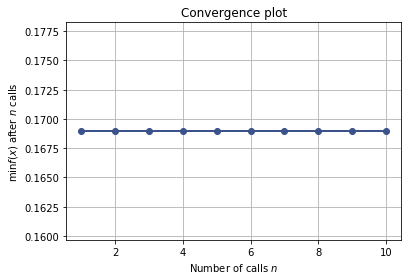

In [26]:
xgb = xgboost.XGBClassifier(
        n_estimators=10000, # use large n_estimators deliberately to make use of the early stopping
        objective='binary:logistic',
        n_jobs=-1
    )

optimizer = XgbOptimizer(xgb, X_train, y_train)
params_space = [Real(0.01, 0.8, name='learning_rate')]
optimal_learning_rate = optimizer.optimize(params_space)

//anaconda/envs/py36/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
//anaconda/envs/py36/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
//anaconda/envs/py36/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
//anaconda/envs/py36/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
//anaconda/envs/py36/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has be

optimal_parameters: {'max_depth': 10, 'min_child_weight': 1}
optimal score: 0.15696600000000005
optimization time: 359.20912194252014
updating model with optimal values


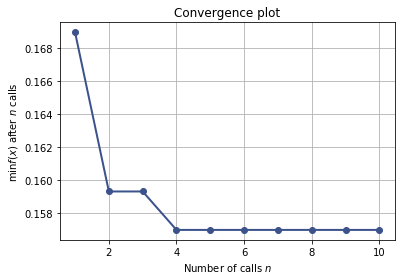

In [13]:
params_space = [
    Integer(2, 10, name='max_depth'), 
    Integer(1, 20, name='min_child_weight')
]
optimal_values = optimizer.optimize(params_space)

//anaconda/envs/py36/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


optimal_parameters: {'subsample': 1.0, 'colsample_bytree': 0.5}
optimal score: 0.14649933333333331
optimization time: 153.99357199668884
updating model with optimal values


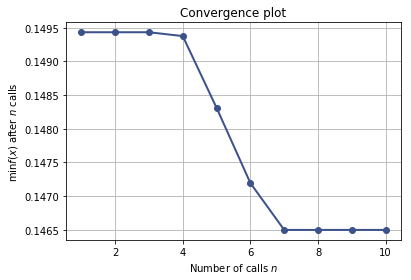

In [14]:
params_space = [
    Real(0.5, 1.0, name='subsample'), 
    Real(0.5, 1.0, name='colsample_bytree')
]
optimal_values = optimizer.optimize(params_space)

//anaconda/envs/py36/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
//anaconda/envs/py36/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


optimal_parameters: {'scale_pos_weight': 1.1641637638603328, 'reg_lambda': 0.27907024511039108}
optimal score: 0.14789933333333327
optimization time: 331.8529460430145
updating model with optimal values


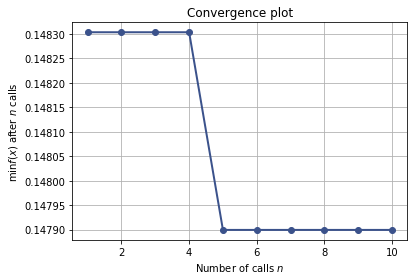

In [15]:
params_space = [
    Real(1.0, 16.0, name='scale_pos_weight'), 
    Real(0.0, 100, name='reg_lambda')
]
optimal_values = optimizer.optimize(params_space)

In [16]:
optimizer.model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.11389587749465084,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=10000, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=0.27907024511039108, scale_pos_weight=1.1641637638603328,
       seed=None, silent=True, subsample=1.0)

### One Step Optimization

Now, let's try optimize all parameters at once

optimal_parameters: {'learning_rate': 0.67223896686498585, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 1.0, 'colsample_bytree': 0.55573119810948801, 'scale_pos_weight': 4.7653377382656146, 'reg_lambda': 41.999717427219672}
optimal score: 0.15428966666666677
optimization time: 1021.6322882175446
updating model with optimal values


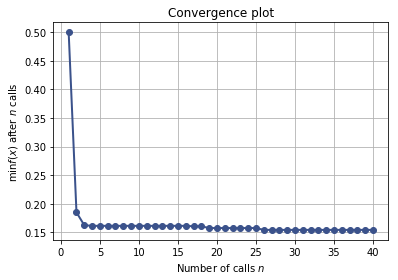

In [17]:
xgb = xgboost.XGBClassifier(
        n_estimators=10000, # use large n_estimators deliberately to make use of the early stopping
        objective='binary:logistic',
        n_jobs=-1
    )
one_optimizer = XgbOptimizer(xgb, X_train, y_train)
params_space = [Real(0.01, 0.8, name='learning_rate'), 
                Integer(2, 10, name='max_depth'), 
                Integer(1, 20, name='min_child_weight'), 
                Real(0.5, 1.0, name='subsample'), 
                Real(0.5, 1.0, name='colsample_bytree'), 
                Real(1.0, 16.0, name='scale_pos_weight'), 
                Real(0.0, 100, name='reg_lambda')]
one_optimal_values = one_optimizer.optimize(params_space, max_evals=40)

In [18]:
one_optimizer.model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.55573119810948801, gamma=0,
       learning_rate=0.67223896686498585, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=10000, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=41.999717427219672,
       scale_pos_weight=4.7653377382656146, seed=None, silent=True,
       subsample=1.0)

### XGBoost Model Analysis

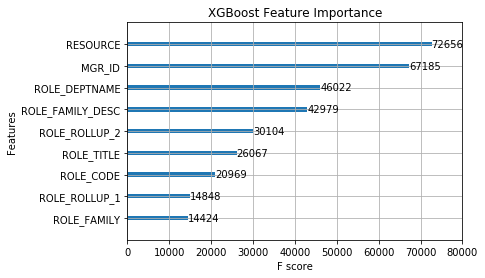

In [19]:
xgb = optimizer.model
xgb.fit(X_train, y_train)
xgboost.plot_importance(xgb, title='XGBoost Feature Importance')

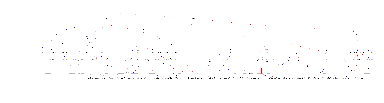

In [20]:
xgboost.plot_tree(xgb)

# LightGBM

### Default Params

In [42]:
default_lgbm = lgb.LGBMClassifier(
        objective='binary',
        n_jobs=-1
    )

default_lgbm_optimizer = LightGBMOptimizer(default_lgbm, X_train, y_train)
default_lgbm_optimizer.evaluate_model()

//anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:426: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
//anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/basic.py:731: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


0.17081815725206184

### Greedy Parameter Tuning

//anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:426: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
//anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/basic.py:731: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))
//anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:426: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
//anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/basic.py:731: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))
//anaconda/envs/py36/lib/python3.6/site-pa

optimal_parameters: {'learning_rate': 0.029503887680470645}
optimal score: 0.16261525073814642
optimization time: 272.7972300052643
updating model with optimal values


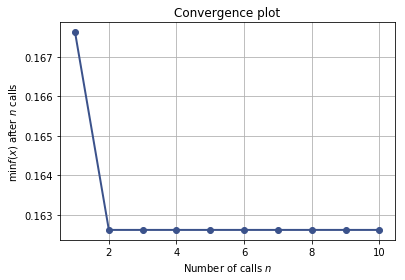

In [43]:
greedy_lgbm = lgb.LGBMClassifier(n_estimators=10000, # use large n_estimators deliberately to make use of the early stopping
        objective='binary',
        n_jobs=-1)
greedy_lgbm_optimizer = LightGBMOptimizer(greedy_lgbm, X_train, y_train)
params_space = [Real(0.01, 0.8, name='learning_rate'),]
greedy_lgbm_optimal_values = greedy_lgbm_optimizer.optimize(params_space)

//anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:426: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
//anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/basic.py:731: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))
//anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:426: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
//anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/basic.py:731: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))
//anaconda/envs/py36/lib/python3.6/site-pa

optimal_parameters: {'max_depth': 12, 'min_child_weight': 19, 'min_child_samples': 11}
optimal score: 0.16409085683763314
optimization time: 56.877371311187744
updating model with optimal values


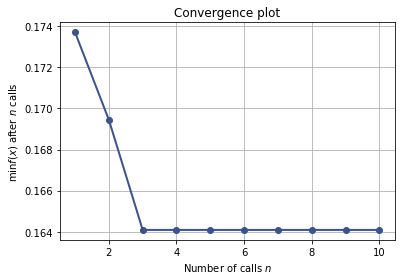

In [45]:
params_space = [
    Integer(2, 12, name='max_depth'), 
    Integer(1, 20, name='min_child_weight'),
    Integer(10, 50, name='min_child_samples')
]
optimal_values = greedy_lgbm_optimizer.optimize(params_space)

//anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:426: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
//anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/basic.py:731: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))
//anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:426: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
//anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/basic.py:731: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))
//anaconda/envs/py36/lib/python3.6/site-pa

optimal_parameters: {'subsample': 0.56575688449028538, 'colsample_bytree': 0.51234423270915863}
optimal score: 0.16118322495576842
optimization time: 35.994566917419434
updating model with optimal values


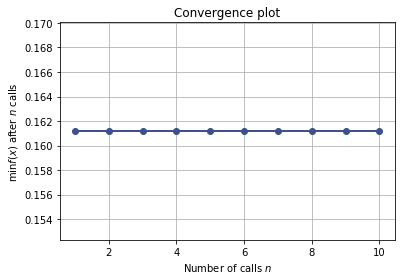

In [46]:
params_space = [
    Real(0.5, 1.0, name='subsample'), 
    Real(0.5, 1.0, name='colsample_bytree')
]
optimal_values = greedy_lgbm_optimizer.optimize(params_space)

//anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:426: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
//anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/basic.py:731: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))
//anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:426: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
//anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/basic.py:731: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))
//anaconda/envs/py36/lib/python3.6/site-pa

optimal_parameters: {'scale_pos_weight': 1.0159778912964188, 'reg_lambda': 99.98878100074144}
optimal score: 0.16329087171254664
optimization time: 102.0387589931488
updating model with optimal values


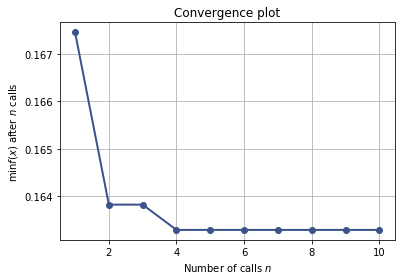

In [48]:
params_space = [
    Real(1.0, 16.0, name='scale_pos_weight'), 
    Real(0.0, 100, name='reg_lambda')
]
optimal_values = greedy_lgbm_optimizer.optimize(params_space)

## One Step Optimization

//anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:426: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
//anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/basic.py:731: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))
//anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:426: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
//anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/basic.py:731: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))
//anaconda/envs/py36/lib/python3.6/site-pa

optimal_parameters: {'learning_rate': 0.80000000000000004, 'max_depth': 6, 'min_child_weight': 1, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5, 'scale_pos_weight': 1.0, 'reg_lambda': 100.0}
optimal score: 0.16043433220379644
optimization time: 957.0893239974976
updating model with optimal values


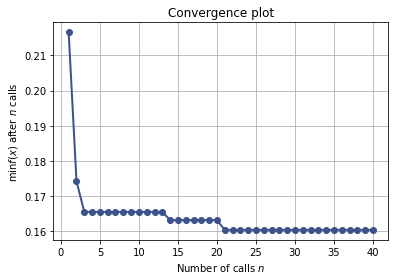

In [50]:
lgbm = lgb.LGBMClassifier(n_estimators=10000, # use large n_estimators deliberately to make use of the early stopping
        objective='binary',
        n_jobs=-1)
lgbm_optimizer = LightGBMOptimizer(lgbm, X_train, y_train)
params_space = [Real(0.01, 0.8, name='learning_rate'), 
                Integer(2, 12, name='max_depth'), 
                Integer(1, 20, name='min_child_weight'),
                Integer(10, 50, name='min_child_samples'),
                Real(0.5, 1.0, name='subsample'), 
                Real(0.5, 1.0, name='colsample_bytree'), 
                Real(1.0, 16.0, name='scale_pos_weight'), 
                Real(0.0, 100, name='reg_lambda')]
lgbm_optimal_values = lgbm_optimizer.optimize(params_space, max_evals=40, n_random_starts=4)

# Catboost

### Default Params

In [23]:
default_cb = catboost.CatBoostClassifier(loss_function='Logloss', eval_metric='AUC', silent=True)
default_cb_optimizer = CatboostOptimizer(default_cb, X_train, y_train)
default_cb_optimizer.evaluate_model()

Training on fold [0/3]

bestTest = 0.8982656571
bestIteration = 129

Training on fold [1/3]

bestTest = 0.8968645308
bestIteration = 361

Training on fold [2/3]

bestTest = 0.9072427451
bestIteration = 136



0.9845727335273811

### Greedy Parameter Tuning

Training on fold [0/3]

bestTest = 0.9017033564
bestIteration = 60

Training on fold [1/3]

bestTest = 0.8952680552
bestIteration = 84

Training on fold [2/3]

bestTest = 0.9118188595
bestIteration = 85

Training on fold [0/3]

bestTest = 0.8967545065
bestIteration = 112

Training on fold [1/3]

bestTest = 0.8912398171
bestIteration = 237

Training on fold [2/3]

bestTest = 0.9077322412
bestIteration = 155

Training on fold [0/3]

bestTest = 0.8916709329
bestIteration = 20

Training on fold [1/3]

bestTest = 0.892331079
bestIteration = 16

Training on fold [2/3]

bestTest = 0.9075166833
bestIteration = 18

Training on fold [0/3]

bestTest = 0.9061627103
bestIteration = 84

Training on fold [1/3]

bestTest = 0.8923467967
bestIteration = 83

Training on fold [2/3]

bestTest = 0.911349572
bestIteration = 91

Training on fold [0/3]

bestTest = 0.8975448854
bestIteration = 36

Training on fold [1/3]

bestTest = 0.894589946
bestIteration = 42

Training on fold [2/3]

bestTest = 0.9081656023


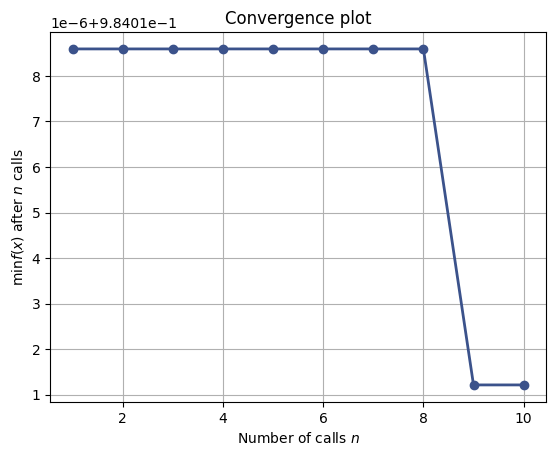

In [24]:
cb = catboost.CatBoostClassifier(n_estimators=4000, # use large n_estimators deliberately to make use of the early stopping
                         one_hot_max_size=2,
                         loss_function='Logloss',
                         eval_metric='AUC',
                         boosting_type='Ordered', # use permutations
                         random_seed=2405, 
                         use_best_model=True,
                         silent=True)
cb_optimizer = CatboostOptimizer(cb, X_train, y_train)
params_space = [Real(0.01, 0.8, name='learning_rate'),]
cb_optimal_values = cb_optimizer.optimize(params_space)

In [25]:
params_space = [Integer(2, 10, name='max_depth'),]
cb_optimal_values = cb_optimizer.optimize(params_space)

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

Training on fold [0/3]

bestTest = 0.9035872426
bestIteration = 35

Training on fold [1/3]

bestTest = 0.8946887434
bestIteration = 43

Training on fold [2/3]

bestTest = 0.9085293563
bestIteration = 30

Training on fold [0/3]

bestTest = 0.8979760012
bestIteration = 21

Training on fold [1/3]

bestTest = 0.8890640297
bestIteration = 44

Training on fold [2/3]

bestTest = 0.9088437115
bestIteration = 23

Training on fold [0/3]

bestTest = 0.897223794
bestIteration = 28

Training on fold [1/3]

bestTest = 0.8977649341
bestIteration = 29

Training on fold [2/3]

bestTest = 0.9086842885
bestIteration = 32

Training on fold [0/3]

bestTest = 0.8989617295
bestIteration = 30

Training on fold [1/3]

bestTest = 0.8961639677
bestIteration = 17

Training on fold [2/3]

bestTest = 0.9046627866
bestIteration = 17

Training on fold [0/3]

bestTest = 0.894601173
bestIteration = 14

Training on fold [1/3]

bestTest = 0.8961347776
bestIteration = 22

Training on fold [2/3]

bestTest = 0.9003898005
be

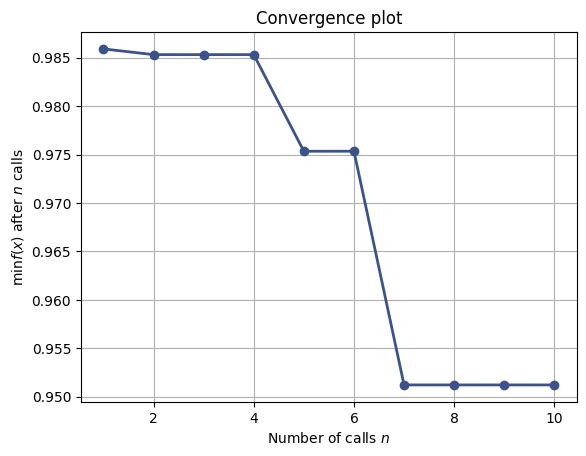

In [14]:
params_space = [
                Real(0.5, 1.0, name='colsample_bylevel'), 
                Real(0.0, 100, name='bagging_temperature'),]
cb_optimal_values = cb_optimizer.optimize(params_space)

Training on fold [0/3]

bestTest = 0.8992019867
bestIteration = 34

Training on fold [1/3]

bestTest = 0.8966646907
bestIteration = 33

Training on fold [2/3]

bestTest = 0.9088190122
bestIteration = 36

Training on fold [0/3]

bestTest = 0.8977447256
bestIteration = 45

Training on fold [1/3]

bestTest = 0.8978031058
bestIteration = 45

Training on fold [2/3]

bestTest = 0.9058775452
bestIteration = 41

Training on fold [0/3]

bestTest = 0.9002056782
bestIteration = 43

Training on fold [1/3]

bestTest = 0.8980994979
bestIteration = 84

Training on fold [2/3]

bestTest = 0.9039397695
bestIteration = 45

Training on fold [0/3]

bestTest = 0.8949492092
bestIteration = 39

Training on fold [1/3]

bestTest = 0.8921514474
bestIteration = 43

Training on fold [2/3]

bestTest = 0.9086932701
bestIteration = 38

Training on fold [0/3]

bestTest = 0.9018672702
bestIteration = 27

Training on fold [1/3]

bestTest = 0.8960157717
bestIteration = 47

Training on fold [2/3]

bestTest = 0.9094971214


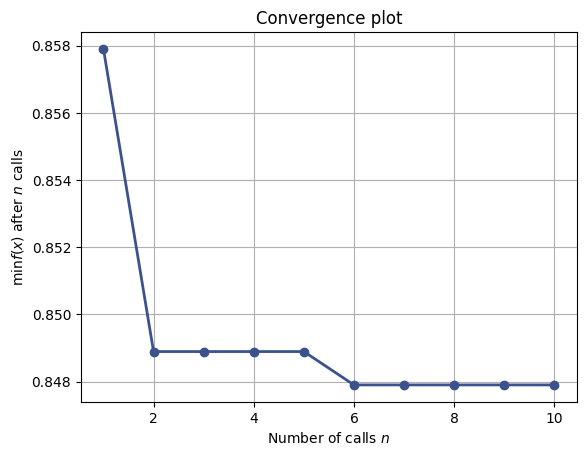

In [15]:
params_space = [
                Real(0.0, 100, name='random_strength'), 
                Real(1.0, 100, name='reg_lambda')]
cb_optimal_values = cb_optimizer.optimize(params_space)

Training on fold [0/3]

bestTest = 0.9010252472
bestIteration = 70

Training on fold [1/3]

bestTest = 0.9019772946
bestIteration = 117

Training on fold [2/3]

bestTest = 0.8999070407
bestIteration = 55

Training on fold [0/3]

bestTest = 0.9030910103
bestIteration = 79

Training on fold [1/3]

bestTest = 0.9022422511
bestIteration = 102

Training on fold [2/3]

bestTest = 0.9057652754
bestIteration = 36

Training on fold [0/3]

bestTest = 0.9002999847
bestIteration = 45

Training on fold [1/3]

bestTest = 0.899749863
bestIteration = 83

Training on fold [2/3]

bestTest = 0.8987955703
bestIteration = 90

Training on fold [0/3]

bestTest = 0.8967140894
bestIteration = 50

Training on fold [1/3]

bestTest = 0.8995006242
bestIteration = 65

Training on fold [2/3]

bestTest = 0.8963278815
bestIteration = 33

Training on fold [0/3]

bestTest = 0.8972372664
bestIteration = 45

Training on fold [1/3]

bestTest = 0.8967387887
bestIteration = 62

Training on fold [2/3]

bestTest = 0.8982095223

(Real(low=1.0, high=16.0, prior='uniform', transform='identity'),)

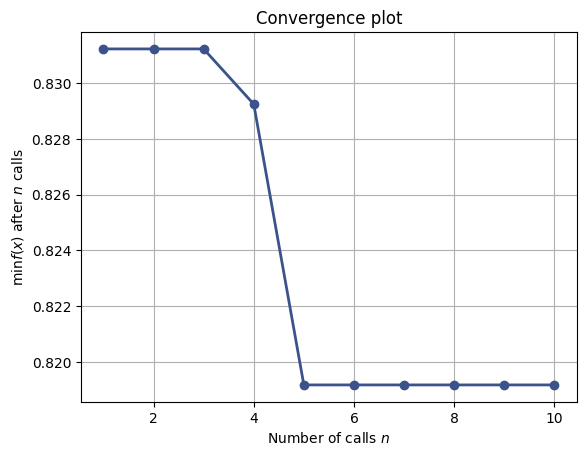

In [21]:
params_space = [Real(1.0, 16.0, name='scale_pos_weight'),]
cb_optimal_values = cb_optimizer.optimize(params_space)
Real(1.0, 16.0, name='scale_pos_weight'), 

In [19]:
cb_optimizer.model.get_params()

{'loss_function': 'Logloss',
 'random_seed': 2405,
 'use_best_model': True,
 'silent': True,
 'one_hot_max_size': 2,
 'eval_metric': 'AUC',
 'boosting_type': 'Ordered',
 'n_estimators': 4000,
 'learning_rate': 0.40884349384515956,
 'colsample_bylevel': 0.7812859750199326,
 'bagging_temperature': 0.0,
 'random_strength': 76.81564986368521,
 'reg_lambda': 78.27935227582829,
 'scale_pos_weight': 16.0}

### One Step Optimization

and now optimizing all parameters at once

optimal_parameters: {'learning_rate': 0.01, 'max_depth': 10, 'colsample_bylevel': 0.60344214270484287, 'scale_pos_weight': 1.0, 'bagging_temperature': 31.988940585038627, 'random_strength': 0.0, 'reg_lambda': 1.0}
optimal score: 0.06812754574887736
optimization time: 12136.701455831528
updating model with optimal values


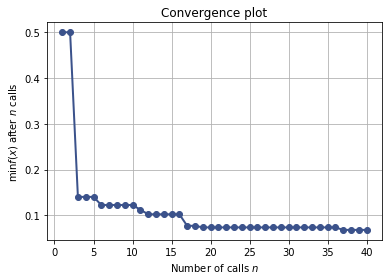

In [30]:
cb = catboost.CatBoostClassifier(n_estimators=4000, # use large n_estimators deliberately to make use of the early stopping
                         one_hot_max_size=2,
                         loss_function='Logloss',
                         eval_metric='AUC',
                         boosting_type='Ordered', # use permutations
                         random_seed=2405, 
                         use_best_model=True,
                         silent=True)
one_cb_optimizer = CatboostOptimizer(cb, X_train, y_train)
params_space = [Real(0.01, 0.8, name='learning_rate'), 
                Integer(2, 10, name='max_depth'), 
                Real(0.5, 1.0, name='colsample_bylevel'), 
                Real(1.0, 16.0, name='scale_pos_weight'), 
                Real(0.0, 100, name='bagging_temperature'), 
                Real(0.0, 100, name='random_strength'), 
                Real(1.0, 100, name='reg_lambda')]
one_cb_optimal_values = one_cb_optimizer.optimize(params_space, max_evals=40, n_random_starts=4)

In [20]:
one_cb_optimizer.model.get_params()

NameError: name 'one_cb_optimizer' is not defined

## Model Analysis

In [32]:
clf = deepcopy(cb_optimizer.model)
pool = catboost.Pool(X_train, y_train, cat_features=categorical_columns_indices)
clf.set_params(use_best_model=False, reg_lambda=1.0)
clf.fit(pool, use_best_model=False)
feature_importance = clf.get_feature_importance(pool, fstr_type=catboost.EFstrType.FeatureImportance, prettified=True)
interactions = clf.get_feature_importance(pool, fstr_type=catboost.EFstrType.Interaction, prettified=True)
shap_values = clf.get_feature_importance(pool, fstr_type=catboost.EFstrType.ShapValues)

The model has complex ctrs, so the SHAP values will be calculated approximately.


### Feature Importance

In [33]:
feature_importance_df = pd.DataFrame(feature_importance, columns=['feature', 'importance'])
feature_importance_df['feature'] = feature_importance_df['feature'].apply(lambda b: b.decode("utf-8"))
feature_importance_df

,feature,importance
0,ROLE_DEPTNAME,17.739511
1,ROLE_ROLLUP_2,13.255139
2,RESOURCE,12.738414
3,MGR_ID,12.414688
4,ROLE_FAMILY_DESC,11.875658
5,ROLE_TITLE,10.591958
6,ROLE_FAMILY,8.398750
7,ROLE_ROLLUP_1,7.164669
8,ROLE_CODE,5.821212


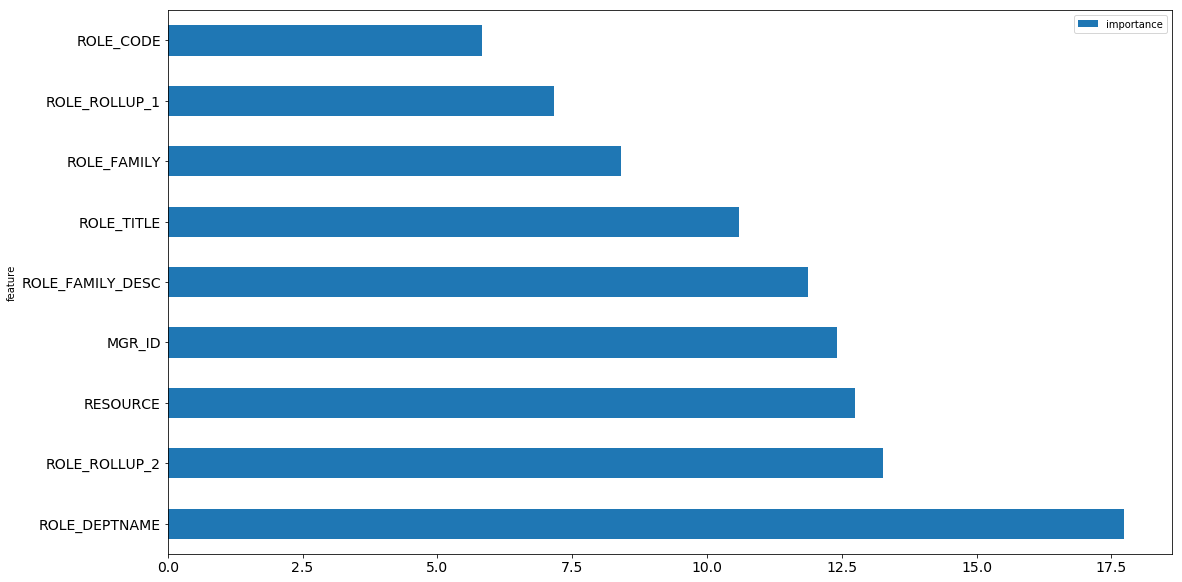

In [34]:
feature_importance_df.set_index('feature').plot(kind='barh', figsize=(18, 10), fontsize=14)

### Feature Interactions

In [35]:
feature_interaction = [[X_train.columns[interaction[0]], X_train.columns[interaction[1]], interaction[2]] for interaction in interactions]
feature_interaction_df = pd.DataFrame(feature_interaction, columns=['feature1', 'feature2', 'interaction_strength'])
feature_interaction_df.head(10)

,feature1,feature2,interaction_strength
0,MGR_ID,ROLE_DEPTNAME,6.717901
1,MGR_ID,ROLE_FAMILY_DESC,5.211672
2,MGR_ID,ROLE_ROLLUP_2,4.899861
3,MGR_ID,ROLE_TITLE,4.658739
4,MGR_ID,ROLE_FAMILY,3.915004
5,RESOURCE,ROLE_DEPTNAME,3.668556
6,ROLE_ROLLUP_2,ROLE_DEPTNAME,3.569978
7,RESOURCE,ROLE_ROLLUP_2,3.468556
8,RESOURCE,ROLE_FAMILY_DESC,3.445613
9,ROLE_DEPTNAME,ROLE_FAMILY_DESC,3.152587


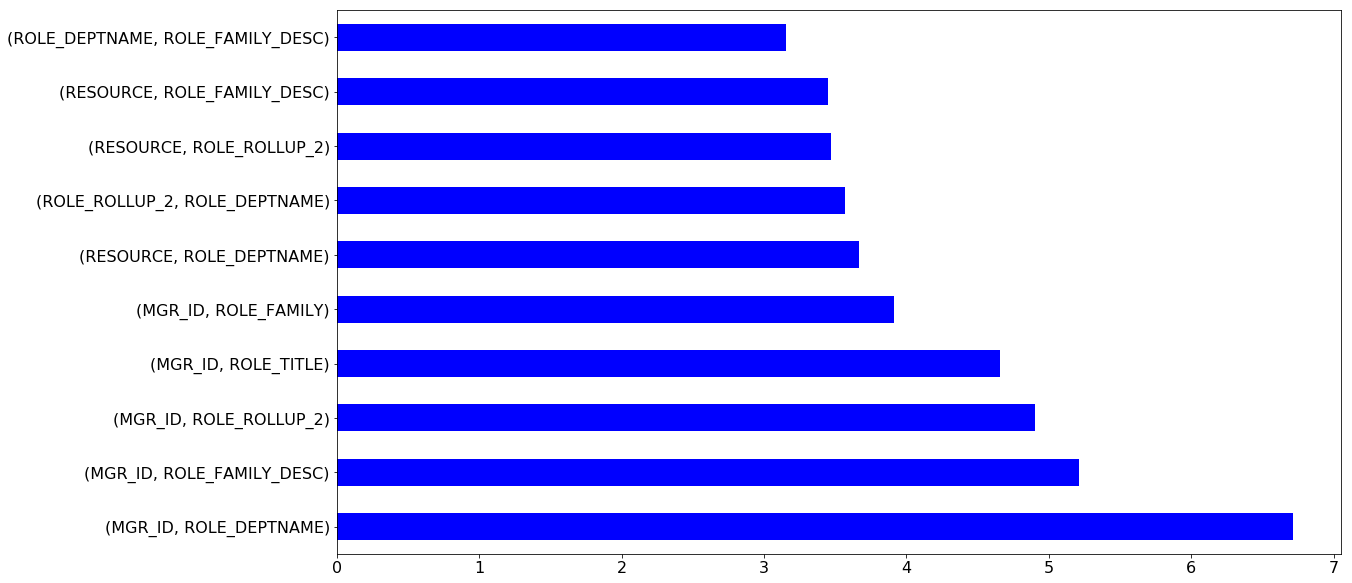

In [36]:
pd.Series(index=zip(feature_interaction_df['feature1'], feature_interaction_df['feature2']), data=feature_interaction_df['interaction_strength'].values, name='interaction_strength').head(10).plot(kind='barh', figsize=(18, 10), fontsize=16, color='b')

### SHAP Values

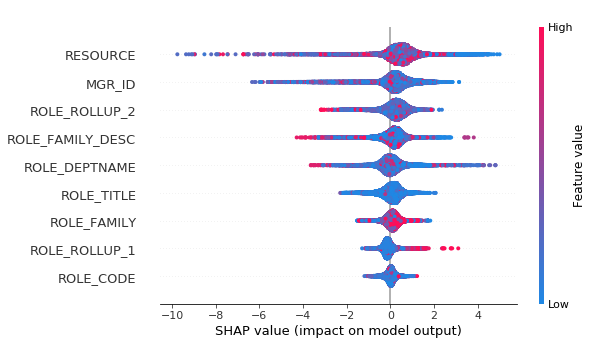

In [37]:
shap.initjs()
shap.summary_plot(shap_values[:, :-1], X_train, feature_names=X_train.columns.tolist())

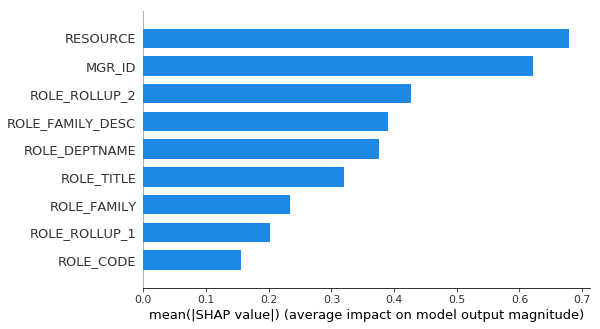

In [38]:
shap.summary_plot(shap_values[:, :-1], X_train, feature_names=X_train.columns.tolist(), plot_type="bar")

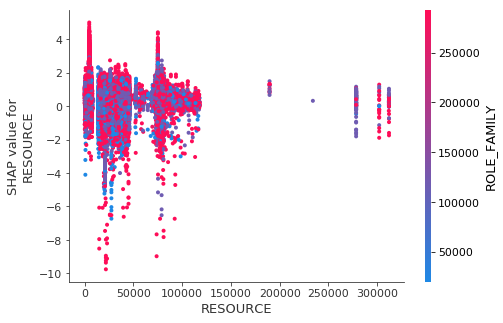

In [39]:
shap.dependence_plot("RESOURCE", shap_values[:, :-1], X_train)

### Object Strength Calculation

In [31]:
indices, scores = clf.get_object_importance(
    pool,
    pool,
    top_size=10,
    ostr_type='Average',
    update_method='SinglePoint',
    thread_count=-1)

In [32]:
object_strength_df = X_train.loc[indices, :]
object_strength_df['strength'] = scores
object_strength_df

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE,strength
10766,6977,29134,117961,118300,123719,118321,117906,290919,118322,2.426877e-07
26606,20222,51734,118256,118257,117945,117946,119235,292795,117948,2.231016e-07
2421,74310,7578,117961,118343,120722,118321,117906,290919,118322,2.130740e-07
27566,18072,51734,118256,118257,117945,117946,119235,292795,117948,1.754674e-07
7716,25993,806,117961,118300,123719,117905,117906,290919,117908,1.733554e-07
2332,18394,818,117961,118300,123719,118784,240983,290919,118786,1.621986e-07
27129,43876,56591,118079,118080,117878,117879,118177,19721,117880,1.563481e-07
318,4675,58719,117961,118386,119954,118318,168365,118205,118319,1.560847e-07
28261,35376,3872,117961,118386,118522,118321,117906,290919,118322,1.483183e-07
7226,6977,54618,117961,118052,118821,118321,117906,290919,118322,1.322214e-07


In [33]:
strength_s = object_strength_df.loc[:, ['strength']]
strength_s.index.name = 'index'
strength_s

,strength
index,
10766,2.426877e-07
26606,2.231016e-07
2421,2.130740e-07
27566,1.754674e-07
7716,1.733554e-07
2332,1.621986e-07
27129,1.563481e-07
318,1.560847e-07
28261,1.483183e-07


## Training Time Comparison

In [54]:
default_xgb = xgboost.XGBClassifier()
default_cb = catboost.CatBoostClassifier()

In [74]:
start_time = time.time()
default_xgb.fit(X_train, y_train)
default_xgb_time = time.time() - start_time
start_time = time.time()
default_cb.fit(X_train, y_train, cat_features=categorical_columns_indices, early_stopping_rounds=30, silent=True)
default_cb_time = time.time() - start_time

Learning rate set to 0.044978


In [53]:
start_time = time.time()
default_lgbm.fit(X_train, y_train)
default_lgbm_time = time.time() - start_time

In [ ]:
greedy_xgb = optimizer.model
bayesian_xgb = one_optimizer.model
greedy_cb = cb_optimizer.model
bayesian_cb = one_cb_optimizer.model

In [54]:
start_time = time.time()
greedy_lgbm.fit(X_train, y_train)
greedy_lgbm_time = time.time() - start_time
start_time = time.time()
lgbm.fit(X_train, y_train)
lgbm_time = time.time() - start_time

In [ ]:
start_time = time.time()
greedy_xgb.fit(X_train, y_train)
greedy_xgb_time = time.time() - start_time
start_time = time.time()
bayesian_xgb.fit(X_train, y_train)
bayesian_xgb_time = time.time() - start_time
start_time = time.time()
greedy_cb.fit(X_train, y_train, cat_features=categorical_columns_indices, early_stopping_rounds=30)
greedy_cb_time = time.time() - start_time
start_time = time.time()
bayesian_cb.fit(X_train, y_train, cat_features=categorical_columns_indices, early_stopping_rounds=30)
bayesian_cb_time = time.time() - start_time
print('greedy_xgb_time:{}\nbayesian_xgb_time:{}\ngreedy_cb:{}\nbayesian_cb:{}'.format(greedy_xgb_time, bayesian_xgb_time, greedy_cb_time,bayesian_cb_time))

In [ ]:
greedy_xgb.fit(X_train, y_train)
greedy_xgb_time = time.time() - start_time
greedy_xgb.fit(X_train, y_train)
greedy_xgb_time = time.time() - start_time


In [75]:
print('default_xgb_time:{}\ndefault_cb_time:{}\ngreedy_xgb_time:{}\nbayesian_xgb_time:{}\ngreedy_cb:{}\nbayesian_cb:{}'.format(default_xgb_time, default_cb_time, greedy_xgb_time, bayesian_xgb_time, greedy_cb_time,bayesian_cb_time))

default_xgb_time:1.6484837532043457
default_cb_time:177.2008500099182
greedy_xgb_time:242.83236694335938
bayesian_xgb_time:292.3313229084015
greedy_cb:2322.492970943451
bayesian_cb:349.6256330013275


In [56]:
print('default_lgbm_time:{}\ngreedy_lgbm_time:{}\nbayesian_lgbm_time:{}'.format(default_lgbm_time, greedy_lgbm_time, lgbm_time))

default_lgbm_time:0.8382151126861572
greedy_lgbm_time:72.50021982192993
bayesian_lgbm_time:50.25921368598938


## Prediction Time Comparison

In [58]:
ids = X_test['id']
X_test = X_test.drop('id', axis=1)

In [76]:
def get_predictions(model, model_name):
    start_time = time.time()
    preds = model.predict(X_test)
    print(model_name, time.time() - start_time)
    return preds

default_xgb_predictions = get_predictions(default_xgb, 'default_xgb')
default_cb_predictions = get_predictions(default_cb, 'default_cb')
greedy_xgb_predictions = get_predictions(greedy_xgb, 'greedy_xgb')
bayesian_xgb_predictions = get_predictions(bayesian_xgb, 'bayesian_xgb')
greedy_cb_predictions = get_predictions(greedy_cb, 'greedy_cb')
bayesian_cb_predictions = get_predictions(bayesian_cb, 'bayesian_cb')

default_xgb 0.22521114349365234
default_cb 0.6515042781829834
greedy_xgb 165.79796981811523
bayesian_xgb 203.83735704421997
greedy_cb 1.6643500328063965
bayesian_cb 0.6867678165435791


In [59]:
default_lgbm_predictions = get_predictions(default_lgbm, 'default_lgbm')
greedy_lgbm_predictions = get_predictions(greedy_lgbm, 'greedy_lgbm')
lgbm_predictions = get_predictions(lgbm, 'lgbm')

default_lgbm 0.2079601287841797
greedy_lgbm 36.18482518196106
lgbm 25.38125205039978


## Summary

In [60]:
pd.read_clipboard('\t', index_col=0)

,Default Catboost,“Greedy” Catboost,“One Step” Catboost,Default XGBoost,“Greedy” XGBoost,“One Step” XGBoost,Default LGBM,“Greedy” LGBM,“One Step” LGBM
Column1,,,,,,,,,
Training Time,2m 57s,38m 42s,5m 49s,1s,4m 2s,4m 52s,0.8s,1m 13s,50s
Optimization Time,-,2h 9m 2s,3h 22m 16s,-,27m 52s,17m 1s,-,7m 47s,15m 57s
"Prediction Time (58921, 9)",0.651s,1.664s,0.686s,0.225s,2m 45s,3m 23s,0.2s,36s,26s
3-Fold AUC,0.862,0.943,0.932,0.746,0.852,0.846,0.829,0.836,0.84


## Conclusions

• Catboost is built with similar approach and attributes as with the "older" generation of GBDT models. <br>
• Catboost power lies with categorical features preprocessing, prediction time and model analysis. <br>
• Catboost weak spots are training & optimization times. <br>
• Don't forget to pass cat_features argument to the classifier object. <br>
• Though Catboost perform well with default parameters, there are some parameters which drive a significant improvement results when tuned.